##Oxford Pet 데이터 다운 및 압축 해제

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [ ]:
# data 디렉토리 생성 후 압축 풀기
!mkdir /content/data
!tar -xvf images.tar.gz -C /content/data
!tar -xvf annotations.tar.gz -C /content/data

## Custom dataset class 구현

- TrainDataset을 만들 때 txt_file 에서 이미지 이름과 라벨 정보를 기준으로 실제 이미지 파일경로를 찾아 연결하였습니다
- TrainDataset에서 이미지를 128*128 크기로 조정 및 정규화를 적용하여 데이터를 변환하였습니다
- 전체 학습데이터에서 20%를 검증데이터로 사용하였습니다.

In [3]:
import os
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader, random_split

class Dataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):
        self.data = []
        self.root_dir = root_dir
        self.transform = transform

        with open(txt_file, 'r') as f:
            for line in f:
                items = line.strip().split()
                image_name, label = items[0], int(items[1]) - 1  # 0-based 인덱스
                self.data.append((image_name, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, label = self.data[idx]
        # 이미지 파일 경로 생성
        image_path = os.path.join(self.root_dir, image_name + ".jpg")

        # 이미지 로드
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file {image_path} not found.")

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


# 데이터 변환 및 DataLoader 설정
full_transform = Compose([
    Resize((128, 128)),  # 이미지 크기 조정
    ToTensor(),          # 텐서로 변환
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화 추가
])
images_dir = "/content/data/images/"
trainval_txt = "/content/data/annotations/trainval.txt"
test_txt = "/content/data/annotations/test.txt"


# 데이터셋 생성
train_dataset = Dataset(txt_file=trainval_txt, root_dir=images_dir, transform=full_transform)

# Train과 val분리
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Test Dataset
test_dataset = Dataset(txt_file = test_txt, root_dir=images_dir, transform=full_transform)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## CNN 모델 구축

**Convolution층**: 4개
- 첫 번째 합성곱: 32개의 출력채널, 커널크기: 3*3, 패딩: 1
- 두 번째 합성곱: 64개의 출력채널, 커널크기: 3*3, 패딩: 1
- 세 번째 합성곱: 128개의 출력채널, 커널크기: 3*3, 패딩: 1
- 네 번째 합성곱: 256개의 출력채널, 커널크기: 3*3, 패딩: 1

**pooling**
- 각 합성곱뒤에 2*2 MaxPooling 적용(stride = 2)

**Fully Connected층**: 2개
- 첫 번째 FC: 입력크기256 -> 출력크기 128
- 두 번째 FC: 입력크기 128 -> 최종 클래스 수로 출력하였습니다

**Dropout**
- 완전 연결층에서 드롭아웃 사용하여 Fully Connected층에서 과적합을 방지하기 위해 사용하였습니다

**Skip Connection**
- 첫 번째와 두번째 블록 사이에서 적용하여 정보 손실 방지 및 기울기 소실 문제를 줄이기 위해 사용하였습니다.

**Global Average Pooling**
- 마지막 합성곱 뒤에 적용하여 출력 크기를 고정하였습니다.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Skip Connection
        self.skip_conv1 = nn.Conv2d(32, 64, kernel_size=1, stride=2, bias=False)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully Connected Layer
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):

        x1 = F.relu(self.bn1(self.conv1(x)))
        x1 = self.pool1(x1)

        x2 = F.relu(self.bn2(self.conv2(x1)))
        x2 = self.pool2(x2)

        # Skip Connection
        x1_resized = self.skip_conv1(x1)
        x2 = x2 + x1_resized

        x3 = F.relu(self.bn3(self.conv3(x2)))
        x3 = self.pool3(x3)

        x4 = F.relu(self.bn4(self.conv4(x3)))
        x4 = self.pool4(x4)

        # Global Average Pooling
        x5 = self.global_avg_pool(x4)
        x5 = torch.flatten(x5, 1)

        # Fully Connected Layer
        x6 = F.relu(self.fc1(x5))
        x6 = self.dropout(x6)

        # 최종 출력
        out = self.fc2(x6)
        return out


## 손실 함수와 옵티마이저 설정

- Optimizer로 AdamW를 사용하였습니다
- Scheduler를 사용해 5step마다 학습률을 조정하였습니다

In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

num_classes = max(label for _, label in train_dataset) + 1
model = CNN(num_classes = num_classes)

# 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# GPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


## 모델 학습 및 평가 함수

In [7]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Optimizer 초기화
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        # loss 누적
        running_loss += loss.item()

        # 정확도 계산
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total * 100
    return avg_loss, accuracy

# 모델 평가
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    # 평가중에는 기울기 막음
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            loss = criterion(outputs, labels)
            # loss 누적
            running_loss += loss.item()

            # 정확도 계산
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct / total * 100
    return avg_loss, accuracy



## 결과 출력

- Test Accuracy 가 21.89%가 나오는 것을 확인했습니다

In [8]:
# 결과 저장 리스트
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

num_epochs = 30
for epoch in range(num_epochs):
    # 학습
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # 결과 출력
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print("-" * 50)

    # 스케쥴러 사용
    scheduler.step()

# 학습 종료 후 테스트 평가
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1/30
Train Loss: 3.6034, Train Accuracy: 4.31%
Validation Loss: 3.5483, Validation Accuracy: 6.93%
--------------------------------------------------
Epoch 2/30
Train Loss: 3.5366, Train Accuracy: 5.30%
Validation Loss: 3.4808, Validation Accuracy: 8.29%
--------------------------------------------------
Epoch 3/30
Train Loss: 3.4728, Train Accuracy: 7.34%
Validation Loss: 3.4904, Validation Accuracy: 5.57%
--------------------------------------------------
Epoch 4/30
Train Loss: 3.4325, Train Accuracy: 7.88%
Validation Loss: 3.3890, Validation Accuracy: 7.88%
--------------------------------------------------
Epoch 5/30
Train Loss: 3.3652, Train Accuracy: 8.53%
Validation Loss: 3.3384, Validation Accuracy: 9.78%
--------------------------------------------------
Epoch 6/30
Train Loss: 3.2882, Train Accuracy: 11.07%
Validation Loss: 3.2502, Validation Accuracy: 13.18%
--------------------------------------------------
Epoch 7/30
Train Loss: 3.2351, Train Accuracy: 11.58%
Validati

## 실험의 Training log 시각화

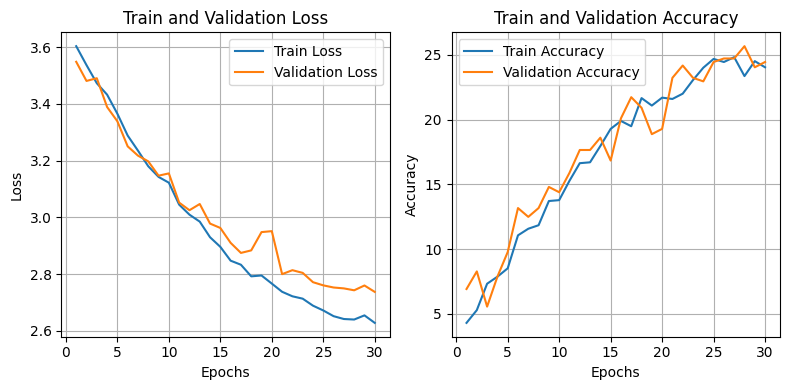

In [20]:
import matplotlib.pyplot as plt

# 그래프 크기
plt.figure(figsize=(8, 4))

# 첫 번째 그래프: 손실
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)

# 두 번째 그래프: 정확도
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 분석 및 고찰

**정확도가 낮은 이유**
- Oxford-IIIT Pet 데이터셋은 크기가 작고, 클래스가 세부적인 품종으로 나뉘어 있어서 모델이 충분히 학습하기 어려웠던 것 같습니다
- 30 에폭만으로는 데이터셋을 충분히 학습하기에 부족한 것을 확인할 수 있었습니다.

**개선 방안**
- 에폭을 더 늘려서 학습을 진행하거나 학습률을 초기에 조금 높게 설정해서 점차 감소시키는 방식을 사용해볼수 있을 것 같습니다.
- 학습 데이터에 정규화뿐만 아니라 회전, 좌우 반전, 색상변환 등의 증강 기법을 적용해 데이터에 다양성을 주면 모델의 일반화 능력을 향상시킬 수 있을 것 같습니다.

**CNN 모델 구현에서 겪은 어려움**
- CNN 모델을 구축할 때 합성곱 연산과 풀링 층을 거친 후 완전 연결 층과 연결하는데 있어서 차원 오류가 자주 생겨서 어려움이 있었습니다. 또한 입력데이터가 다운샘플링 과정을 거친후에 차원이 정확하게 출력이 안되서 오류가 발생했었습니다.
- CNN 모델 설계 시에 각 층의 출력 차원을 잘 계산해서 구현하는 것이 중요하다는 것을 느꼈습니다